# Lifted Bergomi IV Smile

In [2]:
# Import necessary libraries
import numpy as np
import math
import numpy.random as npr
from py_vollib_vectorized import vectorized_implied_volatility as iv
import matplotlib.pyplot as plt

- **Weights \( c_i \):**
  $$
  c_i = \frac{(r^{1 - \alpha} - 1) \cdot r^{(1 - \alpha)(i - 1 - \frac{n}{2})}}{\Gamma(\alpha) \, \Gamma(2 - \alpha)}
  $$

- **Mean reversion rates \( x_i \):**
  $$
  x_i = \frac{(1 - \alpha)(r^{2 - \alpha} - 1) \cdot r^{i - 1 - \frac{n}{2}}}{(2 - \alpha)(r^{1 - \alpha} - 1)}
  $$

In [4]:
def compute_c(r, n, alpha):
    c = np.array([(r**(1 - alpha) - 1) * (r**((1 - alpha) * (ii - 1 - n / 2))) / (math.gamma(alpha) * math.gamma(2 - alpha)) for ii in range(1, n + 1)])
    return c

def compute_x(r, n, alpha):
    x = np.array([(1 - alpha) * (r**(2 - alpha) - 1) * (r**(ii - 1 - n / 2)) / ((2 - alpha) * (r**(1 - alpha) - 1)) for ii in range(1, n + 1)])
    return x

## Question 1

$$
V_t^n = \xi_0(t) \exp\left( 
  \eta \sqrt{2H} \Gamma\left(H + \frac{1}{2}\right) \int_0^t K^n(t - s) \, \mathrm{d}W_s 
  - H \eta^2 \Gamma^2\left(H + \frac{1}{2}\right) \int_0^t (K^n(s))^2 \, \mathrm{d}s 
\right),
$$

$$
\mathrm{d}S_t^n = S_t^n \sqrt{V_t^n} \, \mathrm{d}B_t.
$$

In [7]:
def Sim_Lifted_Bergomi(T, M, rn, n, alpha, rho, xi0, eta, H, S0, N):
    delta_t = T / M # time discretization step
    time_grid = np.asarray([delta_t * ii for ii in range(M + 1)])
    # Initialize space for the variables needed
    V, Y, S = np.zeros((N, M + 1)), np.zeros((n, N)), np.zeros((N, M + 1))
    dW, dB = npr.normal(0, np.sqrt(delta_t), (M, N)), npr.normal(0, np.sqrt(delta_t), (M, N))
    dB = rho * dW + np.sqrt(1 - rho**2) * dB
    
    x, c = compute_x(rn, n, alpha), compute_c(rn, n, alpha) # compute weights and mean reversion rates
    x = x.reshape(n, 1)

    # Iterate through time to compute the variance and price process
    S[:, 0] = S0
    for ii in range(M):
        V[:, ii] = xi0 * np.exp(eta * np.sqrt(2 * H) * math.gamma(alpha) * (c @ Y) - (eta**2) * (((delta_t * ii)**(2 * H)) / 2))
        Y = np.exp(-x * delta_t) * (Y + dW[ii, :])
        S[:, ii + 1] = S[:, ii] * (1 + np.sqrt(V[:, ii]) * dB[ii, :])
    V[:, -1] = xi0 * np.exp(eta * np.sqrt(2 * H) * math.gamma(alpha) * (c @ Y) - (eta**2) * (((delta_t * ii)**(2 * H)) / 2))
    
    return time_grid, V, S

In [8]:
# Parameters for the variance and price simulation
T, M, rn, n, alpha, rho, xi0, eta, H, S0 = 1, 10**5, 8, 20, 0.6, -0.9, 0.02, 1.9, 0.1, 1

In [9]:
time_grid, V, S = Sim_Lifted_Bergomi(T, M, rn, n, alpha, rho, xi0, eta, H, S0, 1)

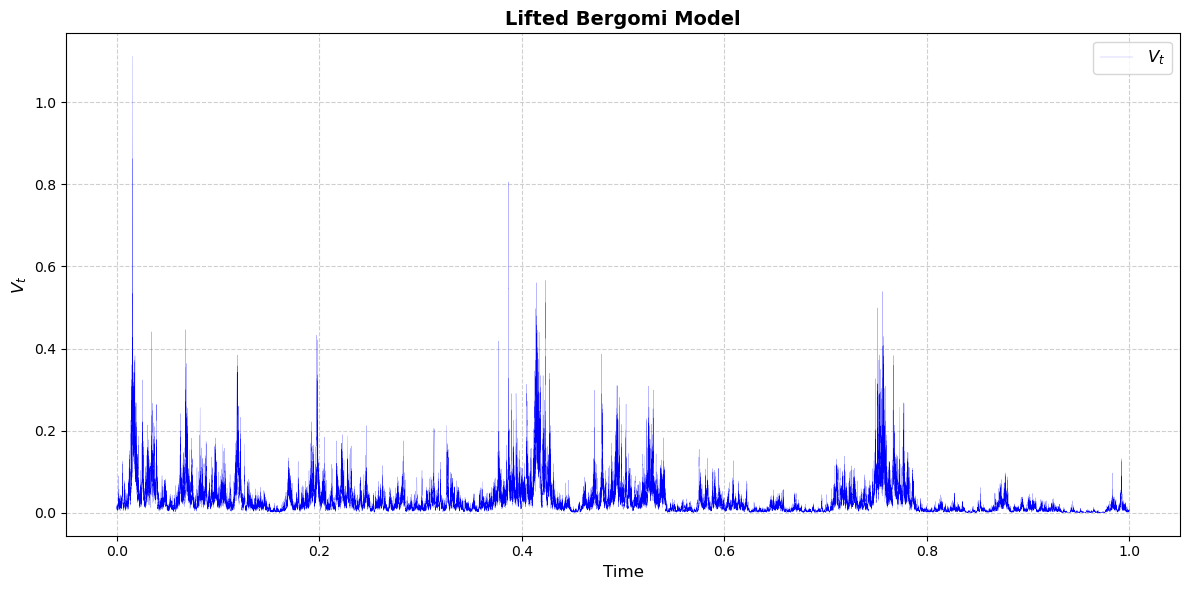

In [10]:
plt.figure(figsize=(12, 6))
plt.title("Lifted Bergomi Model", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel(r'$V_{t}$', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.plot(time_grid, V[0], linewidth=0.1, color='b', label=r'$V_t$')
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()
plt.show()

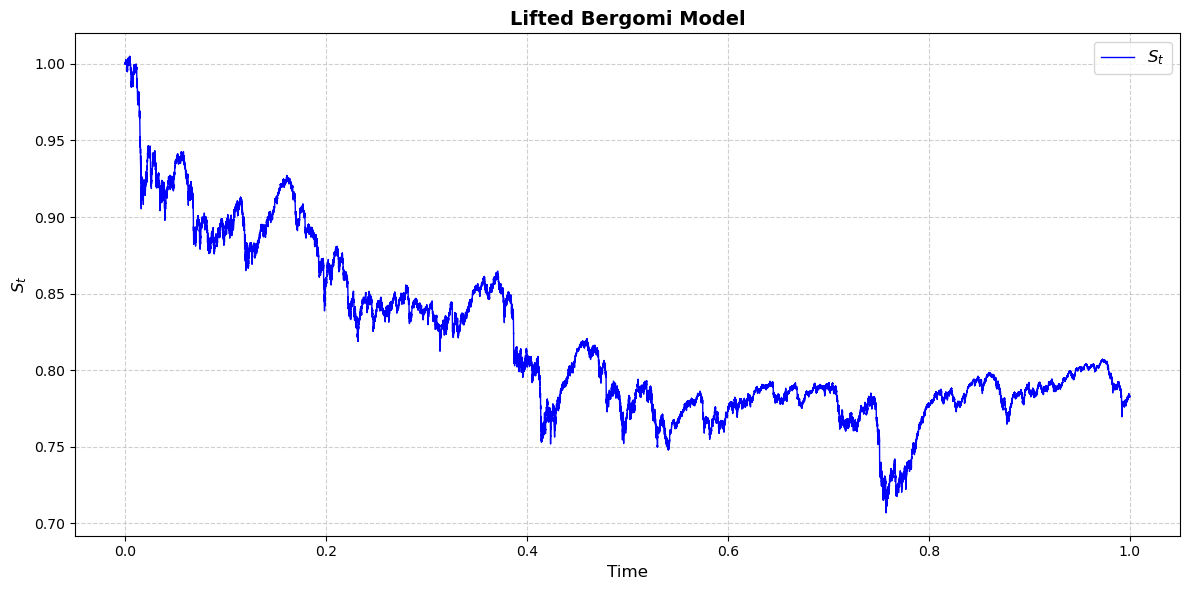

In [11]:
plt.figure(figsize=(12, 6))
plt.title("Lifted Bergomi Model", fontsize=14, fontweight='bold')
plt.xlabel("Time", fontsize=12)
plt.ylabel(r'$S_{t}$', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.plot(time_grid, S[0], linewidth=1, color='b', label=r'$S_t$')
plt.legend(fontsize=12, loc='upper right')
plt.tight_layout()
plt.show()

## Question 2

In [13]:
def Call_Price_Lifted_Bergomi(T, M, rn, n, alpha, rho, xi0, eta, H, S0, K, N = 1000):
    # Monte-Carlo price
    _, _, S = Sim_Lifted_Bergomi(T, M, rn, n, alpha, rho, xi0, eta, H, S0, N)
    payoff = (np.maximum(S[:, -1:] - K, 0))

    price = np.mean(payoff, axis = 0)
    return price

In [14]:
# Parameters for the Monte-Carlo simulation
T, M, rn, n, alpha, rho, xi0, eta, H, S0, K = 1, 10**2, 8, 20, 0.6, -0.9, 0.02, 1.9, 0.1, 1, 1

In [15]:
price = Call_Price_Lifted_Bergomi(T, M, rn, n, alpha, rho, xi0, eta, H, S0, K)
price

array([0.03590088])

## Question 3

In [17]:
# Parameters for the implied volatilities
T, M, alpha, rho, xi0, eta, H, S0 = 1, 10**2, 0.6, -0.9, 0.02, 1.9, 0.1, 1
grid, n_values = 20, [5, 10, 20, 50]

In [18]:
log_K = np.linspace(-0.15, 0.15, grid)
log_K, K = log_K.reshape(grid, 1), np.exp(log_K)
implied_volatilities_list = []

for n in n_values:
    rn = 1 + 10 * (n**(-0.9))
    implied_volatilities = []
    call_price_lifted_bergomi = Call_Price_Lifted_Bergomi(T, M, rn, n, alpha, rho, xi0, eta, H, S0, K, 100000)
    implied_volatilities.append(iv(call_price_lifted_bergomi, S0, np.exp(log_K), T, 0, 'c', return_as='numpy'))
    implied_volatilities_list.append(implied_volatilities)

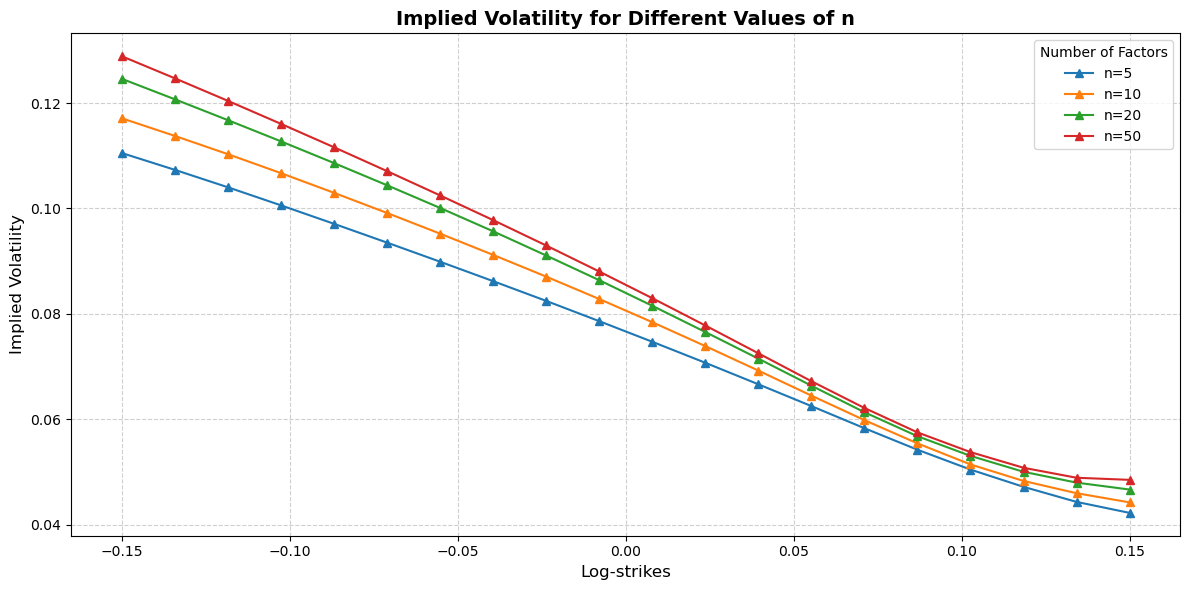

In [19]:
plt.figure(figsize=(12, 6))

for idx, n in enumerate(n_values):
    plt.plot(log_K, implied_volatilities_list[idx][0], marker='^', linestyle='-', label=f"n={n}")

plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel("Log-strikes", fontsize=12)
plt.ylabel("Implied Volatility", fontsize=12)
plt.title("Implied Volatility for Different Values of n", fontsize=14, fontweight='bold')
plt.legend(title="Number of Factors", fontsize=10, loc="upper right")
plt.tight_layout()
plt.show()